In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns
import unidecode, re
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from scipy import *
from sklearn.feature_selection import SelectKBest, f_regression
from catboost import CatBoostClassifier
import lightgbm as lgb
import joblib
from xgboost import XGBClassifier

In [3]:
# Basic config
my_font = dict(
            family="Courier New, monospace",
            size=18,
            color="Black",
            variant="small-caps",
) 

In [4]:
df = pd.read_csv("data/train.csv")
df.head()

,DT_NOTIFIC,CS_SEXO,CO_RG_RESI,ID_MN_RESI,CS_ZONA,NU_IDADE_N,CS_ESCOL_N,CS_RACA,SG_UF,CS_GESTANT,...,TOSSE,GARGANTA,DESC_RESP,DIARREIA,VOMITO,FADIGA,SATURACAO,DISPNEIA,VACINA,EVOLUCAO
0,2020-04-04,F,NaN,RIO DE JANEIRO,1.0,84,9.0,2.0,RJ,5,...,1.0,2.0,1.0,2.0,2.0,NaN,1.0,1.0,9.0,1.0
1,2020-05-07,M,NaN,RIO DE JANEIRO,1.0,68,9.0,9.0,RJ,6,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,9.0,0.0
2,2020-04-23,M,1331.0,SAO PAULO,1.0,44,9.0,4.0,SP,6,...,1.0,2.0,1.0,2.0,2.0,NaN,1.0,1.0,2.0,0.0
3,2020-08-17,M,1553.0,CHAPECO,1.0,87,1.0,1.0,SC,6,...,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0
4,2020-08-14,F,NaN,RIO DE JANEIRO,1.0,91,9.0,9.0,RJ,6,...,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,9.0,0.0


In [5]:
df.isnull().sum()

DT_NOTIFIC         0
CS_SEXO            0
CO_RG_RESI     73185
ID_MN_RESI        44
CS_ZONA        52838
NU_IDADE_N         0
CS_ESCOL_N    146901
CS_RACA        19384
SG_UF             44
CS_GESTANT         0
PUERPERA      298765
DIABETES      252391
PNEUMOPATI    292402
IMUNODEPRE    295546
RENAL         292734
OBESIDADE     290862
OBES_IMC      483795
CARDIOPATI    236183
SIND_DOWN     298085
HEPATICA      297733
FATOR_RISC    179966
FEBRE          60770
TOSSE          52380
GARGANTA      124438
DESC_RESP      83604
DIARREIA      129733
VOMITO        136659
FADIGA        268807
SATURACAO      77360
DISPNEIA       54168
VACINA        101083
EVOLUCAO           0
dtype: int64

In [6]:
df.groupby('SG_UF').size().reset_index(name='count').sort_values(by='count', ascending=False)

,SG_UF,count
25,SP,144896
18,RJ,54916
10,MG,37441
22,RS,25821
17,PR,25644
15,PE,22922
5,CE,19868
4,BA,17989
8,GO,17240
23,SC,16459


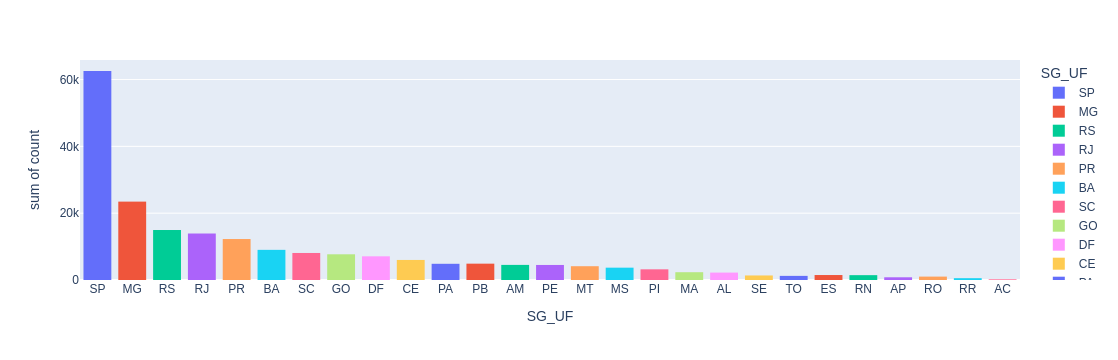

In [7]:
px.histogram(
    df.groupby(['SG_UF','OBESIDADE']).size().reset_index(name='count').sort_values(by='count', ascending=False),
    x='SG_UF',
    y='count',
    color='SG_UF')

In [8]:

x = df.groupby('GARGANTA').size().reset_index(name='count').sort_values(by='count', ascending=False)

px.histogram(
     x,
     x='GARGANTA',
     y='count',
     color='GARGANTA')
x

,GARGANTA,count
1,2.0,272810
0,1.0,88554
2,9.0,12518


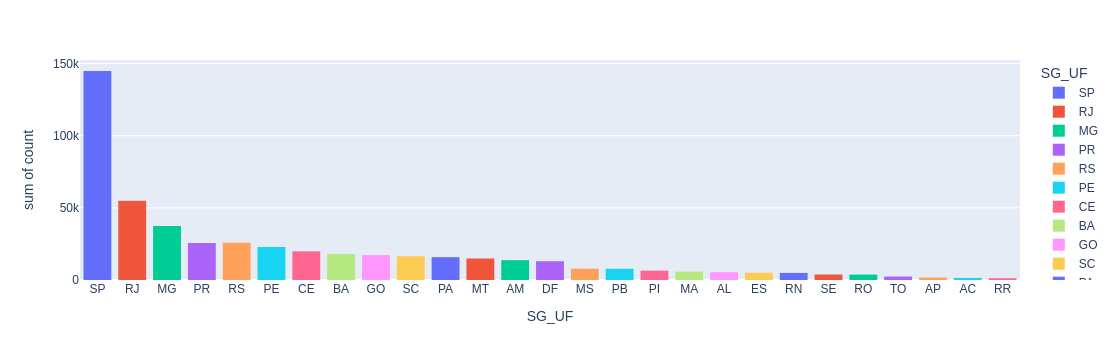

In [9]:
px.histogram(
    df.groupby(['SG_UF','CS_SEXO']).size().reset_index(name='count').sort_values(by='count', ascending=False),
    x='SG_UF',
    y='count',
    color='SG_UF')

In [10]:
X_train = df.select_dtypes(['number']).drop(columns=['EVOLUCAO'])
y_train = df['EVOLUCAO']

X_test = df.select_dtypes(['number'])

In [11]:
X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size = .2, random_state=2)


In [50]:
catb = CatBoostClassifier(
    iterations=100,      
    learning_rate=0.1,   
    depth=6,              
    verbose=0             
)

catb.fit(X_train, y_train)

preds = catb.predict(X_test)

CatBoost's acurracy: 67.89%

Classification report
              precision    recall  f1-score   support

         0.0       0.71      0.87      0.78       632
         1.0       0.54      0.31      0.39       321

    accuracy                           0.68       953
   macro avg       0.63      0.59      0.59       953
weighted avg       0.65      0.68      0.65       953



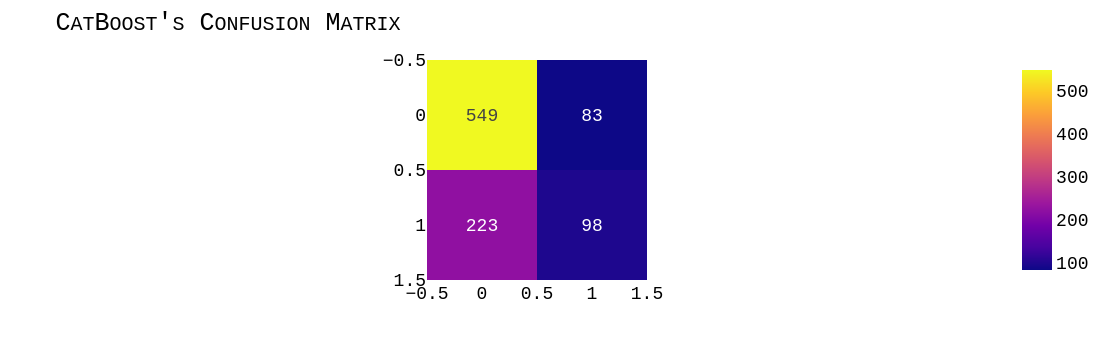

In [51]:
catboost_accuracy = accuracy_score(y_test, preds)
print(f"CatBoost's acurracy: {catboost_accuracy*100:.2f}%")

print("\nClassification report")
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "CatBoost's Confusion Matrix"}, font=my_font).show()


In [48]:
lightGBM = lgb.LGBMClassifier(random_state=23)

lightGBM.fit(X_train, y_train)

preds = lightGBM.predict(X_test)

[LightGBM] [Info] Number of positive: 1249, number of negative: 2562
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 3811, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.327736 -> initscore=-0.718445
[LightGBM] [Info] Start training from score -0.718445


LightGBM acurracy: 68.84%

Classification report
              precision    recall  f1-score   support

         0.0       0.71      0.87      0.78       632
         1.0       0.54      0.31      0.39       321

    accuracy                           0.68       953
   macro avg       0.63      0.59      0.59       953
weighted avg       0.65      0.68      0.65       953



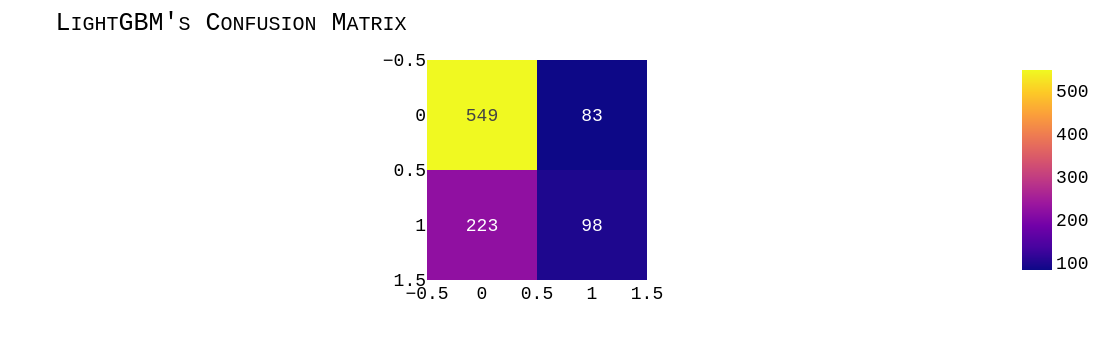

In [52]:
accuracy = lightGBM.score(X_test, y_test)


print(f"LightGBM acurracy: {accuracy*100:.2f}%")
print("\nClassification report")
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "LightGBM's Confusion Matrix"}, font=my_font).show()


In [54]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Accuracy: 66.32

Classification report
              precision    recall  f1-score   support

         0.0       0.70      0.86      0.77       632
         1.0       0.50      0.28      0.36       321

    accuracy                           0.66       953
   macro avg       0.60      0.57      0.57       953
weighted avg       0.63      0.66      0.63       953



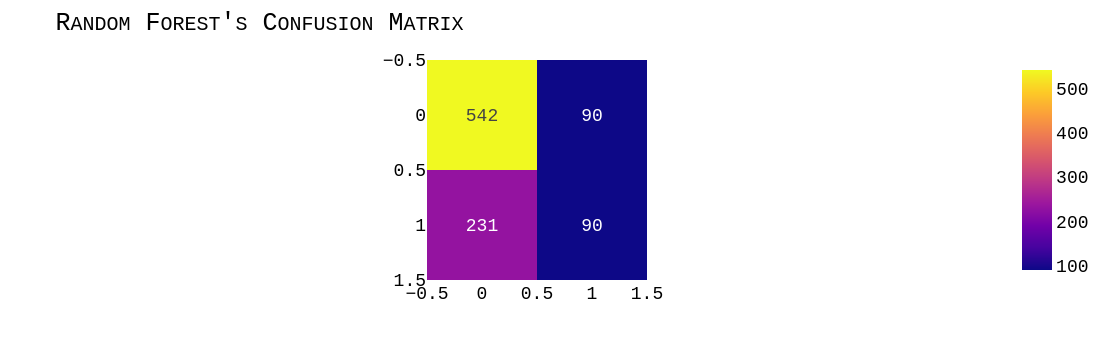

In [55]:
preds = rf.predict(X_test)
accuracy = rf.score(X_test, y_test)

print(f"Accuracy: {accuracy*100:.2f}")
print("\nClassification report")
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "Random Forest's Confusion Matrix"}, font=my_font).show()



In [56]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
preds = xg.predict(X_test)


Accuracy: 68.21

Classification report
              precision    recall  f1-score   support

         0.0       0.73      0.81      0.77       632
         1.0       0.54      0.42      0.47       321

    accuracy                           0.68       953
   macro avg       0.64      0.62      0.62       953
weighted avg       0.67      0.68      0.67       953



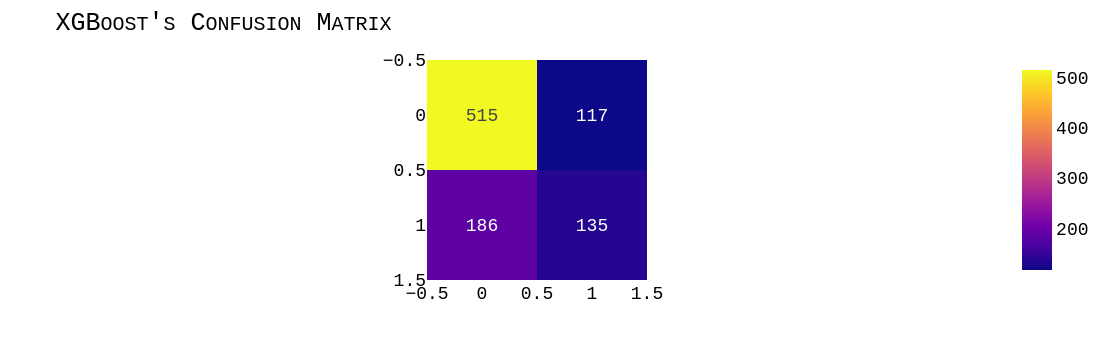

XGBoost's acurracy: 68.84


In [57]:
accuracy = xg.score(X_test, y_test)

print(f"Accuracy: {accuracy*100:.2f}")
print("\nClassification report")
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "XGBoost's Confusion Matrix"}, font=my_font).show()

accuracy = lightGBM.score(X_test, y_test)
print(f"XGBoost's acurracy: {accuracy*100:.2f}")

### Now we can try to treat this dataset
- Let us start by checking what columns have more missing values
- Then we can drop rows with more that 90% of the data NaN

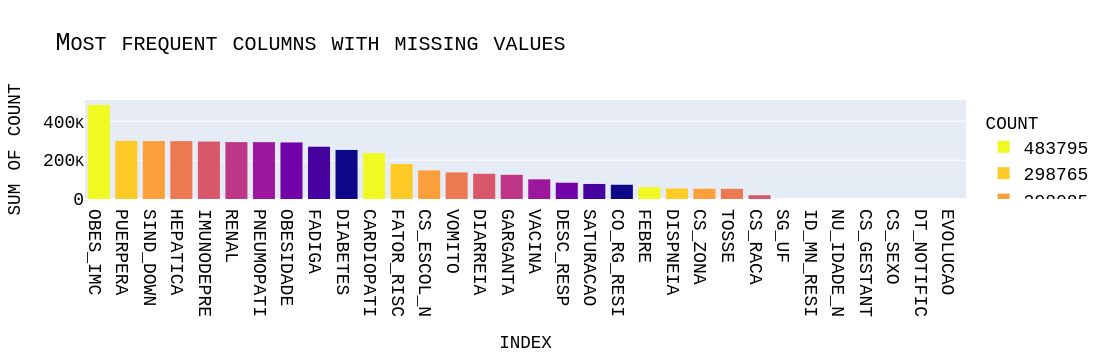

In [58]:
px.histogram(df.isna().sum().reset_index(name='count').sort_values(by='count', ascending=False),
            x='index', y='count', color='count', color_discrete_sequence= px.colors.sequential.Plasma_r,
             title="Most frequent columns with missing values").update_layout(font = my_font)

In [59]:
x = df.isna().sum().reset_index(name='count').sort_values(by='count', ascending=False)
x['pecentage_of_missing_data'] = (x['count'] / len(df))*100
x

,index,count,pecentage_of_missing_data
16,OBES_IMC,483795,97.085206
10,PUERPERA,298765,59.954447
18,SIND_DOWN,298085,59.817988
19,HEPATICA,297733,59.747351
13,IMUNODEPRE,295546,59.308476
14,RENAL,292734,58.744180
12,PNEUMOPATI,292402,58.677557
15,OBESIDADE,290862,58.368518
27,FADIGA,268807,53.942647
11,DIABETES,252391,50.648379


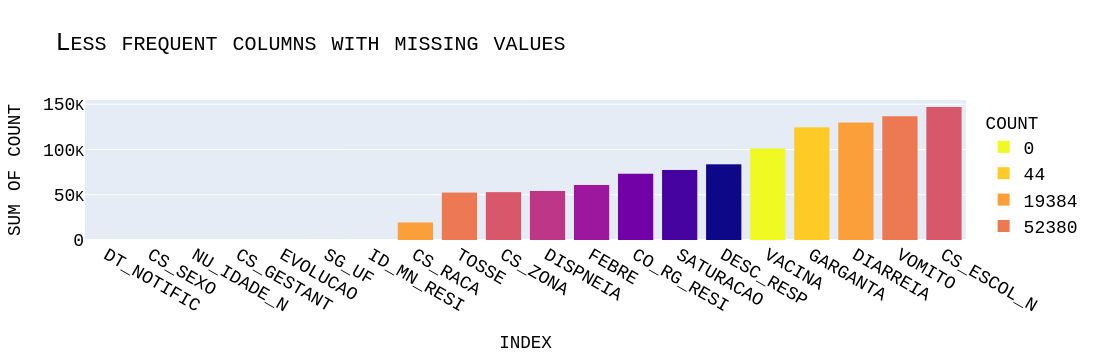

In [28]:
px.histogram(df.isna().sum().reset_index(name='count').sort_values(by='count', ascending=True).head(20),
            x='index', y='count', color='count', color_discrete_sequence= px.colors.sequential.Plasma_r,
             title="Less frequent columns with missing values").update_layout(font = my_font)

In [67]:
missing_counts = df.isnull().sum(axis=1)
thresh = 27
df_no_nulls = df[missing_counts < thresh]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498320 entries, 0 to 498319
Data columns (total 32 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   DT_NOTIFIC  498320 non-null  object 
 1   CS_SEXO     498320 non-null  object 
 2   CO_RG_RESI  425135 non-null  float64
 3   ID_MN_RESI  498276 non-null  object 
 4   CS_ZONA     445482 non-null  float64
 5   NU_IDADE_N  498320 non-null  int64  
 6   CS_ESCOL_N  351419 non-null  float64
 7   CS_RACA     478936 non-null  float64
 8   SG_UF       498276 non-null  object 
 9   CS_GESTANT  498320 non-null  int64  
 10  PUERPERA    199555 non-null  float64
 11  DIABETES    245929 non-null  float64
 12  PNEUMOPATI  205918 non-null  float64
 13  IMUNODEPRE  202774 non-null  float64
 14  RENAL       205586 non-null  float64
 15  OBESIDADE   207458 non-null  float64
 16  OBES_IMC    14525 non-null   float64
 17  CARDIOPATI  262137 non-null  float64
 18  SIND_DOWN   200235 non-null  float64
 19  HE

### Note: You cannot just filter out all columns with ANY missing values
 - The accuracy of all models pretty much drops drastically

In [66]:
df_no_nulls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498320 entries, 0 to 498319
Data columns (total 32 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   DT_NOTIFIC  498320 non-null  object 
 1   CS_SEXO     498320 non-null  object 
 2   CO_RG_RESI  425135 non-null  float64
 3   ID_MN_RESI  498276 non-null  object 
 4   CS_ZONA     445482 non-null  float64
 5   NU_IDADE_N  498320 non-null  int64  
 6   CS_ESCOL_N  351419 non-null  float64
 7   CS_RACA     478936 non-null  float64
 8   SG_UF       498276 non-null  object 
 9   CS_GESTANT  498320 non-null  int64  
 10  PUERPERA    199555 non-null  float64
 11  DIABETES    245929 non-null  float64
 12  PNEUMOPATI  205918 non-null  float64
 13  IMUNODEPRE  202774 non-null  float64
 14  RENAL       205586 non-null  float64
 15  OBESIDADE   207458 non-null  float64
 16  OBES_IMC    14525 non-null   float64
 17  CARDIOPATI  262137 non-null  float64
 18  SIND_DOWN   200235 non-null  float64
 19  HE